# Classifying Lumity Clients by Primary Characteristics
In this Jupyter Notebook demo, we examine information from Lumity's main clients obtained in 2019 and classify clients with similarly related plan characteristics. In particular, Lumity has two types of plan characteristics. The primary characteristics are the client's
* Employee Size
* Average Employee Age
* Percentage of Male Employees
* Standard Industrial Classification (SIC)
* Region Headquarters

The secondary characteristics include the client's
* Medical plan carrier
* Employee/family costs
* Rates

The ultimate goal is to obtain optimal benchmark plan(s) which Lumity can recommend to clients. In this Jupyter notebook, we specifically focus on classifying clients by their primary characteristics. We give a Machine Learning approach using a variation of the famous unsupervised $k$-Means clustering algorithm. The notebook will be detailed and accessible to Lumity's Product Management Team and other interested parties.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import os
import pickle

# Preprocessing Data
Recall from the introduction, we wish to classify clients based on their   
* Employee Size
* Average Employee Age
* Percentage of Male Employees
* Standard Industrial Classification
* Region Headquarters

At the time of writing, the 'Demographics.csv' file contains primary characteristic information for $126$ different clients. Each row in the dataframe is a datapoint with an individual client's primary characteristics as its entries. 

Before we apply the clustering algorithms, we will do some preprocessing on the dataframe. First, we eliminate clients with any incomplete/missing primary characteristic data. $\textbf{As of writing, there are $113$ clients that have complete information out of $126$ total clients}.$ Then, we take certain columns and convert their values to integers or floats. Finally, we extract the SIC Code and put it into a separate column. We show the output of the first $5$ rows of the dataframe after preprocessing.

In [10]:
df=pd.read_csv('Demographics.csv')[['Client/Prospect','Size', 'Region (HQ)', 'SIC Code - Industry', 
                         'Average Employee Age','Percentage Male']] 
print("There are {0} total clients.".format(len(df)))
df=df.dropna(axis=0) #Removing clients with missing/incomplete data
df['Size']=df['Size'].apply(lambda x: int(x))
df['Percentage Male']=df['Percentage Male'].apply(lambda x:float(x[:2]))
df['SIC Code']=df['SIC Code - Industry'].apply(lambda x: x.split("-")[0].strip())
df=df.sort_values(by='Size')
numerical_characteristics=['Size', 'Average Employee Age','Percentage Male']
categorical_characteristics=['SIC Code','Region (HQ)']
primary_characteristics=numerical_characteristics+categorical_characteristics

print("There are {0} total clients with complete information.".format(len(df)))
df.head(5)[['Client/Prospect']+primary_characteristics] 

There are 126 total clients.
There are 113 total clients with complete information.


Client/Prospect  Size  Average Employee Age  Percentage Male SIC Code  \
38         Feedzai     5                 41.85             60.0     7372   
96     Rock Health    11                 28.27             36.0     8621   
81        NimbleRx    31                 30.70             55.0     7372   
75          Movoto    34                 36.40             59.0     6531   
66          Legion    37                 40.00             84.0     7374   

     Region (HQ)  
38      Bay Area  
96      Bay Area  
81      Bay Area  
75  Pennsylvania  
66      Bay Area

Notice that Size, Average Employee Age, and Percentage of Males are $\textbf{numerical (quantitative) characteristics}.$ This means that the data obtained for these characteristics are physical measurements. On the other hand, notice that Region (HQ), and SIC Code are $\textbf{categorical (qualitative) characteristics}.$ This means that the data obtained for these characteristics are not quantitative numbers, but qualitative categories.

# k-Means Clustering

We have a set of $d$ datapoints $\mathcal{D}= \lbrace \mathbf{x}_1, \ \dots \ , \mathbf{x}_d \rbrace,$ where each $\mathbf{x}_i$ contains $n$ component values. In Lumity's case, there are $d=113$ datapoints corresponding to $113$ clients available for analysis. Explicitly, each $\mathbf{x}_i$ from $\mathcal{D}$ is a vector of the format $\textbf{x}_i=(x_{i,1}, \ \dots \ , x_{i,n}),$ where $x_{i,j}$ is the value of the $j$-th feature of the $i$-th datapoint. In Lumity's case, $n=5,$ the total number of primary characteristics, and $x_{i,j}$ is the value of the $j$-th primary characteristic for Client $i.$ 

We want to determine $\textbf{clusters (groups)}$ of datapoints such that datapoints in a cluster are similarly related to one another. For example, we should have clients with over $1000$ employees fall into one cluster, while clients with less than $100$ employees fall into another cluster. 

We determine such groups by the $K$-means algorithm. The goal of $K$-means is to determine a collection of $K$ different $n$-dimensional $\textbf{centroid}$ vectors $\mathcal{C}= \lbrace \mathbf{\mu}_1, \ \dots \ , \mathbf{\mu}_K \rbrace.$ Each centroid $\mathbf{\mu}_k$ from $\mathcal{C}$ corresponds to the center of the $k$-th cluster and possesses "average" properties of datapoints in that cluster. For example, a cluster with clients over $1000$ employees must have a centroid such that its component containing the average number of employees has a value bigger than $1000.$

The algorithm declares two datapoints $\mathbf{x}_a$ and $\mathbf{x}_b$ from $\mathcal{D}$ are $\textbf{similar}$ if there is a centroid $\mu_k$ from $\mathcal{C}$ that is closest to both $\mathbf{x}_a$ and $\mathbf{x}_b$ in Euclidean Distance. The $\textbf{Euclidean Distance}$ of the $n$-dimensional vectors $\mathbf{p}=(p_1, \ \dots \ , p_n)$ and $\mathbf{q}=(q_1, \ \dots \ , q_n)$ is defined to be the number
$$\|\mathbf{p}-\mathbf{q}\|=\sqrt{(p_1-q_1)^2 + \ \dots \ + (p_n-q_n)^2}.$$ 


$K$-means is implemented as follows. We fix a value $K,$ which is the number of clusters we wish to partition our dataset $\mathcal{D}$ into. It initializes centroids $\mu_1, \ \ \dots \ , \mu_K$ to be random points in $n$-dimensional space. Then, it iteratively updates these centroids using a specific Expectation Maximation formula to minimize the cost function $$f(\mu_1, \ \dots \ , \mu_K)= \sum_{i=1}^d\sum_{k=1}^K a_{i,k} \|\mathbf{x}_i-\mu_k\|^2,$$ where $$a_{i,k}=\begin{cases} 1 & \mathbf{x}_i \text{ placed into Cluster $k$} \\ 0 & \text{else} \end{cases}.$$ At each iteration, for every datapoint $\mathbf{x}_i$ from $\mathcal{D},$ we seek the center $\mu_k$ from $\mathcal{C}$ that minimizes $\|\mathbf{x}_i-\mu_k\|.$ This means $\mathbf{x}_i$ will be put into Cluster $k.$

# k-Modes Clustering

But the $K$-means algorithm described in the previous section will not directly work on the client dataset. $K$-means assumes all datapoints have only numerical features (for the Euclidean Distance to make sense). Recall from earlier SIC Code and Region Headquarters are categorical features. How do we modify the approach then to account for this situation ? This is where the $K$-Modes algorithm comes into play.  

First, we need to define what it means to take 'distances' of $2$ categorical values. Let $\mathbf{P}=(P_1, \ \dots \ , P_r)$ and $\mathbf{Q}=(Q_1, \ \dots \ , Q_r)$ be $2$ different datapoints possessing categorical values in their entries. We define their $\textbf{Hamming Distance}$ to be the number 
$$\|P-Q\|_H = \delta(P_1,Q_1) + \ \dots \ + \delta(P_r,Q_r),$$ where $$\delta(P_i,Q_i)= \begin{cases} 0 & \text{ if $P_i=Q_i$} 
\\ 1 & \text{ if $P_i \neq Q_i$} \end{cases}.$$ In Layman's terms, the Hamming Distance counts the number of dissimilar component values between $P$ and $Q.$ The smaller this number is, the 'closer' $P$ and $Q$ are. 

For example, say Client $A$ is based in the Bay Area and has SIC Code $7371$ (i.e. $A$ is a computer programming service) and client $B$ is based in New York but also has the same SIC code $7371.$ The hamming distance between these categorical features of $A$ and those of $B$ is equal to $0+1=1,$ since both clients are based in different locations but are of the same industry type. 

Analagous to the goal of $K$-means, the goal of $K$-modes is to determine a collection of $K$ different $r$-dimensional $\textbf{mode}$ vectors $\mathcal{M}= \lbrace \mathbf{m}_1, \ \dots \ , \mathbf{m}_K \rbrace.$ Each centroid $\mathbf{m}_k$ from $\mathcal{M}$ corresponds to the center of the $k$-th cluster of categorical datapoints, but possesses 'modal' properties of datapoints in that cluster.  For example, a cluster with clients with a majority of clients located in the Bay Area must have a mode vector such that the component containing the regional headquarters should be Bay Area. 

$K$-modes is implemented as follows. We fix a value $K,$ which is the number of clusters we wish to partition our categorical dataset $\mathcal{E}=\lbrace \textbf{P}_1, \ \dots \ , \textbf{P}_s \rbrace$ into, where $\mathbf{P}_i=(P_{i,1},  \ \dots \ , P_{i,r}).$ It initializes modes $\mathbf{m}_1, \ \ \dots \ , \mathbf{m}_K$ to be random points in $r$-dimensional space. Then, it iteratively updates these modes using a specific Expectation Maximation formula to minimize the cost function $$g(\mathbf{m}_1, \ \dots \ , \mathbf{m}_K)= \sum_{i=1}^d\sum_{k=1}^K b_{i,k} \| \mathbf{P}_i- \mathbf{m}_k \|_H,$$ where $$b_{i,k}=\begin{cases} 1 & \mathbf{x}_i \text{ placed into Cluster $k$} \\ 0 & \text{else} \end{cases}.$$ At each iteration, for every datapoint $\mathbf{P}_i$ from $\mathcal{E},$ we seek the mode $\mathbf{m}_k$ from $\mathcal{M}$ that minimizes $\|\mathbf{P}_i-\mathbf{m}_k\|.$ This means $\mathbf{P}_i$ will be put into Cluster $k.$

# k-Prototypes Clustering

On Lumity's dataset $\mathcal{D},$ we combine implementations of $K$-means and $K$-modes together into an algorithm called $K$-prototypes. $K$-prototypes uses $K$-means on the numerical characteristics and $K$-modes on the categorical characteristics. The output of $K$-prototypes is $K$ different centers, where each center either has an 'average' entry (if based on a numerical feature) or a 'modal' entry (if based on a categorical feature).
We seek centers $\nu_1, \ \dots \ , \nu_K$ so that we minimize the cost function: 
$$h(\nu_1, \ \dots \ , \nu_K)= \sum_{i=1}^d\sum_{k=1}^K c_{i,k} d(\mathbf{x}_i,\nu_k),$$ where $$c_{i,k}=\begin{cases} 1 & \mathbf{x}_i \text{ placed into Cluster $k$} \\ 0 & \text{else} \end{cases}$$ and
$$d(\mathbf{x}_i,\nu_k)= \sum_{j \ : \ x_{i,j} \text{ numerical}} \|x_{i,j} - \nu_{k,j}\| + \sum_{j \ : \ x_{i,j} \text{ categorical}} \|x_{i,j} - \nu_{k,j}\|_H. $$ 

The question remains how to choose $K$ suitably ? In practice, we use what is known as the $\textbf{elbow method}.$ For small values of $K,$ i.e. $K$ in between $1$ and $10,$ we run the $K$-prototypes algorithm to obtain the centers, and we plot the resulting cost $h.$ As $K$ increases, $h$ decreases but stagnates after a certain $K$ value. In Layman's terms, after a certain $K$ value, there is a 'law of diminishing returns' choosing a higher number of clusters. We show give a plot of the elbow method below. 

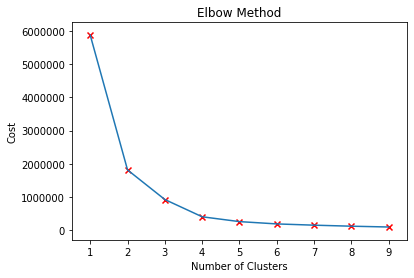

In [11]:
def build_kp_model(X=df[primary_characteristics],K=4):
    model=KPrototypes(n_clusters=K,n_init=100,init='Huang')
    column_index_dict=dict(zip(primary_characteristics,
                               range(len(primary_characteristics))))
    fitted_model=model.fit_predict(X,categorical=[column_index_dict[feature]
                                                  for feature in categorical_characteristics])
    file_path=os.getcwd()+"/Prototype_Models"
    try:
        os.makedirs(file_path, exist_ok=False)
    except OSError:
        pass
    pickle.dump(model,open(file_path+"/{0}_Prototype_Model.sav".format(K),'wb'))
    return model

def generate_kp_models(stop=10):
    for K in range(1,stop+1):
        build_kp_model(K=K)
    

def load_kp_model(K):
    file_path=os.getcwd()+"/Prototype_Models"
    model=pickle.load(open(file_path+"/{0}_Prototype_Model.sav".format(K), 'rb'))
    return model

def kp_elbow_method(X=df[primary_characteristics], max_K=10):
    
    costs=[load_kp_model(K).cost_ for K in range(1,max_K)]
    fig,ax=plt.subplots()
    ax.plot(range(1,len(costs)+1),costs)
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Cost")
    ax.set_title("Elbow Method")
    ax.scatter(range(1,len(costs)+1),costs,marker='x',color='red')
    return ax

kp_elbow_method()

The plot above shows that it is sufficient to specify $4$ or $5$ clusters for $K$-prototypes because that is where the cost begins to stagnate. In the cell below, we run $K$-prototypes with $K=4$ clusters on our dataset. The clusters are labeled from $0, \ \dots \ ,3.$ $\textbf{WARNING: These cluster labels are randomly shuffled around each time the algorithm is run}.$ To make labeling consistent throughout trials, we reorder the labels so they are in increasing order everytime. 

The output of the code below will be a tuple of $2$ lists (each of length $K$) and a dictionary. The first list will contain $K$ different dataframes, where the $i$-th dataframe consists of clients placed into the $i$-th cluster. The second list will contain $K$ different dictionaries, where the $i$-th dictionary is the $i$-th centroid corresponding to the $i$-th cluster. The dictionary returned is a relabeling index dictionary, which we will need when predicting labels of incoming client data.

In [12]:
def get_kp_clusters_and_centroids(model,Y=df):
    Y['kp_Labels']=model.labels_
    unique_labels=list(Y['kp_Labels'].unique()) 
    K=len(unique_labels)
    modified_labels=range(K)
    relabel_dict=dict(zip(unique_labels, modified_labels))
    Y['kp_Labels']=Y['kp_Labels'].apply(lambda x: relabel_dict[x]) #Reordering randomized labels in increasing order
    kp_clusters=[Y[Y['kp_Labels']==k] for k in range(K)]
    file_path=os.getcwd()+"/{0}_Prototypes_Clusters".format(K)
    try:
        os.makedirs(file_path, exist_ok=False)
    except OSError:
        pass
    for i in range(len(kp_clusters)):
        kp_clusters[i].to_csv(file_path+ "/Cluster_{0}_{1}.csv".format(K,i))
    pd.concat(kp_clusters).to_csv(file_path+"/{0}_Demographics_labeled.csv".format(K))
    
    centroids_list=list(np.concatenate(model.cluster_centroids_,axis=1))
    avg_primary_characteristic_keys=['Avg. ' + feature for feature in primary_characteristics]
    centroids_dict=[dict(zip(avg_primary_characteristic_keys,centroids_list[label])) for label in unique_labels]
    return kp_clusters, centroids_dict,relabel_dict

K=4
model=load_kp_model(K)
clusters,centroids,relabel_dict=get_kp_clusters_and_centroids(model)

We now output the first and last clusters along with their centroids.

In [13]:
print(centroids[0])
clusters[0]

{'Avg. Size': '105.36986301369863', 'Avg. Average Employee Age': '36.38849315068494', 'Avg. Percentage Male': '57.821917808219176', 'Avg. SIC Code': '7371', 'Avg. Region (HQ)': 'Bay Area'}


Client/Prospect  Size   Region (HQ)  \
38           Feedzai     5      Bay Area   
96       Rock Health    11      Bay Area   
81          NimbleRx    31      Bay Area   
75            Movoto    34  Pennsylvania   
66            Legion    37      Bay Area   
..               ...   ...           ...   
39   Fisher & Paykel   180   Los Angeles   
37           Factual   184   Los Angeles   
72        MightyHive   192      Bay Area   
121      Wealthfront   194      Bay Area   
101     SmartProcure   199       Florida   

                                   SIC Code - Industry  Average Employee Age  \
38                         7372 - Prepackaged Software                 41.85   
96        8621 - Professional Membership Organizations                 28.27   
81                         7372 - Prepackaged Software                 30.70   
75              6531 - Real Estate Agents and Managers                 36.40   
66   7374 - Workplace Engagement, Analytics, Foreca...                 40.00   
..                                                 ...                   ...   
39                              3639 - Home Appliances                 44.40   
37   7374 - Computer Processing and Data Preparatio...                 32.70   
72                7371 - Computer Programming Services                 29.30   
121                           6282 - Investment Advice                 31.20   
101       7375 - Online Database Information Retrieval                 32.20   

     Percentage Male SIC Code  kp_Labels  
38              60.0     7372          0  
96              36.0     8621          0  
81              55.0     7372          0  
75              59.0     6531          0  
66              84.0     7374          0  
..               ...      ...        ...  
39              71.0     3639          0  
37              54.0     7374          0  
72              51.0     7371          0  
121             71.0     6282          0  
101             66.0     7375          0  

[73 rows x 8 columns]

In [14]:
print(centroids[-1])
clusters[-1]

{'Avg. Size': '1157.6666666666667', 'Avg. Average Employee Age': '34.76666666666667', 'Avg. Percentage Male': '44.666666666666664', 'Avg. SIC Code': '4789', 'Avg. Region (HQ)': 'Bay Area'}


Client/Prospect  Size Region (HQ)               SIC Code - Industry  \
86       Postmates  1102    Bay Area    4789 - Transportation Services   
35           Enjoy  1152    Bay Area  7379 - Computer Related Services   
52           Honor  1219    Bay Area   8082 - Home Healthcare Services   

    Average Employee Age  Percentage Male SIC Code  kp_Labels  
86                  31.2             52.0     4789          3  
35                  30.8             65.0     7379          3  
52                  42.3             17.0     8082          3

# Predicting Labels of Incoming Clients

Now, if a client were to provide its own primary characteristic information, we can predict the cluster it best matches through the centroids. In this case, if $\mathbf{x}=(x_1, \ \dots \ , x_n)$ contains the client's information and if we are given the centroids $\nu_1, \ \dots \ , \nu_K,$ we seek the centroid $\nu_i$ so that $d(\mathbf{x},\nu_i)$ is minimized, where $$d(\mathbf{x},\nu_k)= \sum_{j \ : \ x_{j} \text{ numerical}} \|x_{j} - \nu_{k,j}\| + \sum_{j \ : \ x_{j} \text{ categorical}} \|x_{j} - \nu_{k,j}\|_H. $$ 

We implement this below. We can predict the labels of information given by multiple clients at once.

In [15]:
def predict_label(model,incoming_client_df):
    column_index_dict=dict(zip(primary_characteristics,
                               range(len(primary_characteristics))))
    incoming_client_df['Predicted_kp_Labels']=model.predict(incoming_client_df,
                                                            categorical=[column_index_dict[feature]
                                                  for feature in categorical_characteristics]) #Old Prediction Label
    incoming_client_df['Predicted_kp_Labels']=incoming_client_df['Predicted_kp_Labels'].apply(lambda x: relabel_dict[int(x)])
    #New Prediction Label after Reordering
    return incoming_client_df


def add_client_info(client_data,incoming_client_df=pd.DataFrame(columns=primary_characteristics)): 
    for info in client_data:
        incoming_client_df=incoming_client_df.append(dict(zip(primary_characteristics, info)),
                                                 ignore_index=True)
    return incoming_client_df


def generate_random_data(n=5):
    random_client_data=[[np.random.randint(5,2000),
                         np.random.uniform(20,60),
                         np.random.uniform(10,90),
                         df['SIC Code'].sample().iloc[0], 
                         df['Region (HQ)'].sample().iloc[0]] for i in range(n)]
    random_client_df=add_client_info(random_client_data)
    return random_client_df

ebay_info=[14000,32, 60, '7389', 'Bay Area']  
predict_label(model,add_client_info([ebay_info]))

Size Average Employee Age Percentage Male SIC Code Region (HQ)  \
0  14000                   32              60     7389    Bay Area   

   Predicted_kp_Labels  
0                    3

In [16]:
predict_label(model,generate_random_data())

Size  Average Employee Age  Percentage Male SIC Code Region (HQ)  \
0  1594             43.777046        77.691502     7389    New York   
1  1372             20.364126        19.343902     7374        Ohio   
2  1683             36.034015        54.875468     7371    Bay Area   
3  1327             53.119031        41.985631     7372     Florida   
4  1334             51.225896        22.882336     7373    Bay Area   

   Predicted_kp_Labels  
0                    3  
1                    3  
2                    3  
3                    3  
4                    3